<a href="https://colab.research.google.com/github/cku7808/Stacked-denoising-AE/blob/main/Stacked_Denoising_AE_Random_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

%matplotlib inline

In [52]:
train_data = datasets.MNIST("dataset", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("dataset", train=False, download=True, transform=transforms.ToTensor())

In [53]:
print("number of train data :",len(train_data))
print("number of test data :",len(test_data))

number of train data : 60000
number of test data : 10000


In [54]:
train_data[0] # tuple 형태로 (tensor, label)로 구성

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [55]:
train_data[0][0].shape # (1,28,28)

torch.Size([1, 28, 28])

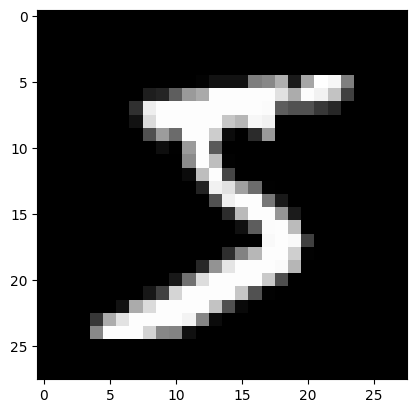

In [56]:
tmp_img, tmp_label = train_data[0]
plt.imshow(tmp_img.squeeze(), cmap="gray")

In [57]:
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

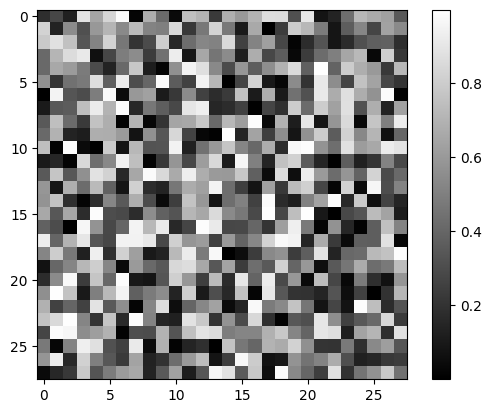

In [58]:
# 랜덤 노이즈 생성하기
noise = np.random.random((28,28))
plt.imshow(noise, cmap="gray")
plt.colorbar()

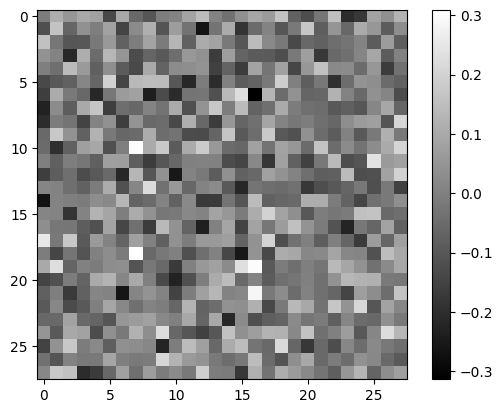

In [59]:
# 노이즈가 너무 강함 - 표준편차가 0.1인 가우시안(정규) 분포를 따르는 랜덤값 추출
noise = np.random.normal(0, 0.1, (28,28))
plt.imshow(noise, cmap="gray")
plt.colorbar()

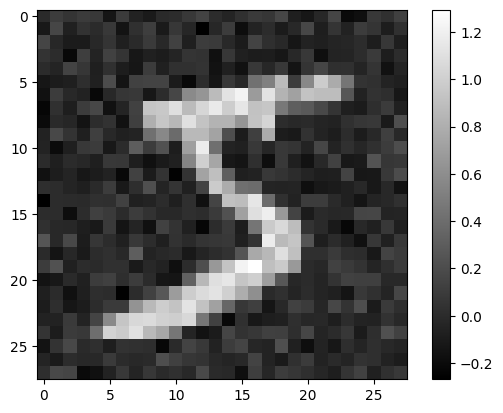

In [60]:
noise_ex = tmp_img.squeeze() + noise
plt.imshow(noise_ex, cmap="gray")
plt.colorbar()

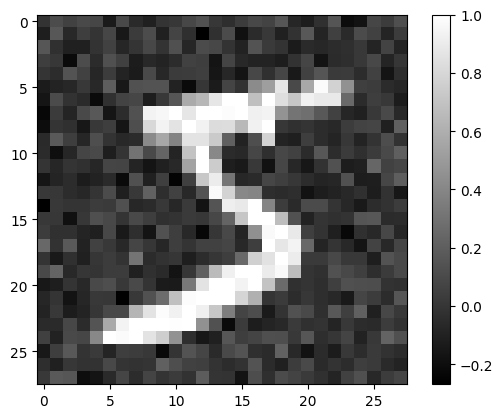

In [61]:
noise_ex[noise_ex > 1.0] = 1.0 # 1을 초과하는 경우 값을 1로 변경
plt.imshow(noise_ex, cmap="gray")
plt.colorbar()

In [62]:
# Stacked Denoising AE
class StackedDenoisingAE(nn.Module):
    def __init__(self, input_size, output_size):
        super(StackedDenoisingAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_size, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, output_size, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_size, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.Sigmoid() # 각 픽셀을 0-1 값으로 변환해야함 (grayscale이므로)
        )

    def forward(self, x):
        en_out_x = self.encoder(x)
        de_out_x = self.decoder(en_out_x)
        return de_out_x

In [63]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sdae_model = StackedDenoisingAE(1,64)
sdae_model = sdae_model.to(device)

In [64]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sdae_model.parameters(), lr=0.0001)
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    for data in tqdm(train_loader, total=len(train_loader)):
        x, _ = data
        x = x.to(torch.float).to(device)
        noise = torch.randn_like(x) * 0.1  # x의 형상을 하는 평균0, 표준편차1인 정규분포에 0.1을 곱해 표준편차를 0.1로 만들기
        noise = noise.to(torch.float).to(device)
        noised_x = x + noise
        noised_x = torch.clamp(noised_x, 0, 1).to(torch.float).to(device)  # [0, 1] 범위로 클리핑 및 GPU로 올리기

        out_x = sdae_model(noised_x)
        loss = criterion(out_x, x)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


100%|██████████| 938/938 [00:09<00:00, 95.18it/s] 


Epoch 1/100, Loss: 0.0276


100%|██████████| 938/938 [00:09<00:00, 95.21it/s] 


Epoch 2/100, Loss: 0.0157


100%|██████████| 938/938 [00:08<00:00, 108.02it/s]


Epoch 3/100, Loss: 0.0157


100%|██████████| 938/938 [00:09<00:00, 96.19it/s] 


Epoch 4/100, Loss: 0.0144


100%|██████████| 938/938 [00:09<00:00, 96.21it/s] 


Epoch 5/100, Loss: 0.0172


100%|██████████| 938/938 [00:09<00:00, 102.39it/s]


Epoch 6/100, Loss: 0.0171


100%|██████████| 938/938 [00:09<00:00, 100.11it/s]


Epoch 7/100, Loss: 0.0138


100%|██████████| 938/938 [00:09<00:00, 95.14it/s] 


Epoch 8/100, Loss: 0.0129


100%|██████████| 938/938 [00:09<00:00, 98.03it/s]


Epoch 9/100, Loss: 0.0121


100%|██████████| 938/938 [00:08<00:00, 105.12it/s]


Epoch 10/100, Loss: 0.0139


100%|██████████| 938/938 [00:09<00:00, 96.64it/s] 


Epoch 11/100, Loss: 0.0119


100%|██████████| 938/938 [00:09<00:00, 97.62it/s] 


Epoch 12/100, Loss: 0.0115


100%|██████████| 938/938 [00:08<00:00, 105.83it/s]


Epoch 13/100, Loss: 0.0110


100%|██████████| 938/938 [00:09<00:00, 94.56it/s] 


Epoch 14/100, Loss: 0.0118


100%|██████████| 938/938 [00:09<00:00, 95.86it/s] 


Epoch 15/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 103.23it/s]


Epoch 16/100, Loss: 0.0111


100%|██████████| 938/938 [00:09<00:00, 101.48it/s]


Epoch 17/100, Loss: 0.0098


100%|██████████| 938/938 [00:09<00:00, 96.63it/s] 


Epoch 18/100, Loss: 0.0101


100%|██████████| 938/938 [00:09<00:00, 97.99it/s]


Epoch 19/100, Loss: 0.0110


100%|██████████| 938/938 [00:08<00:00, 104.72it/s]


Epoch 20/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 95.51it/s] 


Epoch 21/100, Loss: 0.0117


100%|██████████| 938/938 [00:09<00:00, 96.63it/s] 


Epoch 22/100, Loss: 0.0102


100%|██████████| 938/938 [00:08<00:00, 108.22it/s]


Epoch 23/100, Loss: 0.0128


100%|██████████| 938/938 [00:09<00:00, 97.21it/s] 


Epoch 24/100, Loss: 0.0102


100%|██████████| 938/938 [00:09<00:00, 95.43it/s] 


Epoch 25/100, Loss: 0.0107


100%|██████████| 938/938 [00:09<00:00, 103.58it/s]


Epoch 26/100, Loss: 0.0114


100%|██████████| 938/938 [00:09<00:00, 100.06it/s]


Epoch 27/100, Loss: 0.0100


100%|██████████| 938/938 [00:10<00:00, 93.66it/s] 


Epoch 28/100, Loss: 0.0135


100%|██████████| 938/938 [00:09<00:00, 94.09it/s]


Epoch 29/100, Loss: 0.0132


100%|██████████| 938/938 [00:08<00:00, 106.70it/s]


Epoch 30/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 97.49it/s] 


Epoch 31/100, Loss: 0.0111


100%|██████████| 938/938 [00:09<00:00, 95.77it/s] 


Epoch 32/100, Loss: 0.0107


100%|██████████| 938/938 [00:08<00:00, 106.24it/s]


Epoch 33/100, Loss: 0.0107


100%|██████████| 938/938 [00:09<00:00, 95.79it/s] 


Epoch 34/100, Loss: 0.0098


100%|██████████| 938/938 [00:09<00:00, 95.69it/s] 


Epoch 35/100, Loss: 0.0111


100%|██████████| 938/938 [00:09<00:00, 101.72it/s]


Epoch 36/100, Loss: 0.0110


100%|██████████| 938/938 [00:09<00:00, 101.00it/s]


Epoch 37/100, Loss: 0.0097


100%|██████████| 938/938 [00:09<00:00, 96.19it/s] 


Epoch 38/100, Loss: 0.0120


100%|██████████| 938/938 [00:09<00:00, 97.72it/s]


Epoch 39/100, Loss: 0.0101


100%|██████████| 938/938 [00:08<00:00, 105.69it/s]


Epoch 40/100, Loss: 0.0110


100%|██████████| 938/938 [00:09<00:00, 96.64it/s] 


Epoch 41/100, Loss: 0.0116


100%|██████████| 938/938 [00:09<00:00, 95.52it/s] 


Epoch 42/100, Loss: 0.0111


100%|██████████| 938/938 [00:08<00:00, 106.90it/s]


Epoch 43/100, Loss: 0.0102


100%|██████████| 938/938 [00:09<00:00, 94.85it/s] 


Epoch 44/100, Loss: 0.0125


100%|██████████| 938/938 [00:09<00:00, 95.91it/s] 


Epoch 45/100, Loss: 0.0122


100%|██████████| 938/938 [00:09<00:00, 100.13it/s]


Epoch 46/100, Loss: 0.0126


100%|██████████| 938/938 [00:09<00:00, 101.80it/s]


Epoch 47/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 95.73it/s] 


Epoch 48/100, Loss: 0.0108


100%|██████████| 938/938 [00:09<00:00, 97.48it/s]


Epoch 49/100, Loss: 0.0114


100%|██████████| 938/938 [00:08<00:00, 106.84it/s]


Epoch 50/100, Loss: 0.0108


100%|██████████| 938/938 [00:09<00:00, 96.28it/s] 


Epoch 51/100, Loss: 0.0112


100%|██████████| 938/938 [00:09<00:00, 96.04it/s] 


Epoch 52/100, Loss: 0.0108


100%|██████████| 938/938 [00:08<00:00, 107.28it/s]


Epoch 53/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 96.91it/s] 


Epoch 54/100, Loss: 0.0113


100%|██████████| 938/938 [00:09<00:00, 95.31it/s] 


Epoch 55/100, Loss: 0.0129


100%|██████████| 938/938 [00:09<00:00, 103.81it/s]


Epoch 56/100, Loss: 0.0127


100%|██████████| 938/938 [00:09<00:00, 100.89it/s]


Epoch 57/100, Loss: 0.0119


100%|██████████| 938/938 [00:09<00:00, 95.42it/s] 


Epoch 58/100, Loss: 0.0124


100%|██████████| 938/938 [00:09<00:00, 96.18it/s]


Epoch 59/100, Loss: 0.0107


100%|██████████| 938/938 [00:08<00:00, 106.66it/s]


Epoch 60/100, Loss: 0.0107


100%|██████████| 938/938 [00:09<00:00, 95.78it/s] 


Epoch 61/100, Loss: 0.0130


100%|██████████| 938/938 [00:09<00:00, 95.88it/s] 


Epoch 62/100, Loss: 0.0096


100%|██████████| 938/938 [00:08<00:00, 106.68it/s]


Epoch 63/100, Loss: 0.0138


100%|██████████| 938/938 [00:09<00:00, 97.03it/s] 


Epoch 64/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 95.39it/s] 


Epoch 65/100, Loss: 0.0117


100%|██████████| 938/938 [00:09<00:00, 101.63it/s]


Epoch 66/100, Loss: 0.0166


100%|██████████| 938/938 [00:09<00:00, 101.73it/s]


Epoch 67/100, Loss: 0.0115


100%|██████████| 938/938 [00:09<00:00, 96.26it/s] 


Epoch 68/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 96.59it/s]


Epoch 69/100, Loss: 0.0121


100%|██████████| 938/938 [00:08<00:00, 106.64it/s]


Epoch 70/100, Loss: 0.0131


100%|██████████| 938/938 [00:09<00:00, 96.64it/s] 


Epoch 71/100, Loss: 0.0156


100%|██████████| 938/938 [00:09<00:00, 95.81it/s] 


Epoch 72/100, Loss: 0.0131


100%|██████████| 938/938 [00:08<00:00, 105.46it/s]


Epoch 73/100, Loss: 0.0104


100%|██████████| 938/938 [00:09<00:00, 98.06it/s] 


Epoch 74/100, Loss: 0.0105


100%|██████████| 938/938 [00:09<00:00, 97.53it/s] 


Epoch 75/100, Loss: 0.0116


100%|██████████| 938/938 [00:09<00:00, 103.97it/s]


Epoch 76/100, Loss: 0.0103


100%|██████████| 938/938 [00:09<00:00, 103.32it/s]


Epoch 77/100, Loss: 0.0136


100%|██████████| 938/938 [00:09<00:00, 97.73it/s] 


Epoch 78/100, Loss: 0.0113


100%|██████████| 938/938 [00:09<00:00, 99.47it/s]


Epoch 79/100, Loss: 0.0107


100%|██████████| 938/938 [00:08<00:00, 106.10it/s]


Epoch 80/100, Loss: 0.0109


100%|██████████| 938/938 [00:09<00:00, 98.50it/s] 


Epoch 81/100, Loss: 0.0151


100%|██████████| 938/938 [00:09<00:00, 98.78it/s]


Epoch 82/100, Loss: 0.0132


100%|██████████| 938/938 [00:08<00:00, 111.40it/s]


Epoch 83/100, Loss: 0.0101


100%|██████████| 938/938 [00:09<00:00, 100.41it/s]


Epoch 84/100, Loss: 0.0113


100%|██████████| 938/938 [00:09<00:00, 99.82it/s]


Epoch 85/100, Loss: 0.0101


100%|██████████| 938/938 [00:08<00:00, 111.04it/s]


Epoch 86/100, Loss: 0.0141


100%|██████████| 938/938 [00:09<00:00, 100.45it/s]


Epoch 87/100, Loss: 0.0113


100%|██████████| 938/938 [00:09<00:00, 100.36it/s]


Epoch 88/100, Loss: 0.0102


100%|██████████| 938/938 [00:08<00:00, 111.05it/s]


Epoch 89/100, Loss: 0.0114


100%|██████████| 938/938 [00:09<00:00, 100.43it/s]


Epoch 90/100, Loss: 0.0107


100%|██████████| 938/938 [00:09<00:00, 99.25it/s] 


Epoch 91/100, Loss: 0.0137


100%|██████████| 938/938 [00:08<00:00, 110.99it/s]


Epoch 92/100, Loss: 0.0117


100%|██████████| 938/938 [00:09<00:00, 98.72it/s] 


Epoch 93/100, Loss: 0.0101


100%|██████████| 938/938 [00:09<00:00, 99.76it/s] 


Epoch 94/100, Loss: 0.0114


100%|██████████| 938/938 [00:08<00:00, 109.80it/s]


Epoch 95/100, Loss: 0.0169


100%|██████████| 938/938 [00:09<00:00, 100.58it/s]


Epoch 96/100, Loss: 0.0106


100%|██████████| 938/938 [00:09<00:00, 100.28it/s]


Epoch 97/100, Loss: 0.0117


100%|██████████| 938/938 [00:08<00:00, 106.84it/s]


Epoch 98/100, Loss: 0.0175


100%|██████████| 938/938 [00:09<00:00, 102.46it/s]


Epoch 99/100, Loss: 0.0120


100%|██████████| 938/938 [00:09<00:00, 99.29it/s] 

Epoch 100/100, Loss: 0.0135


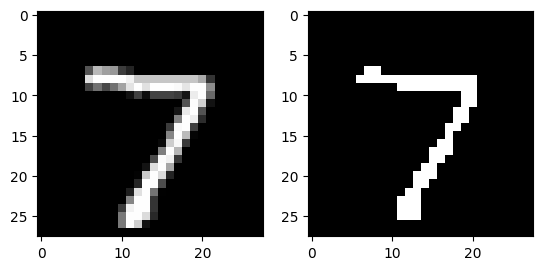

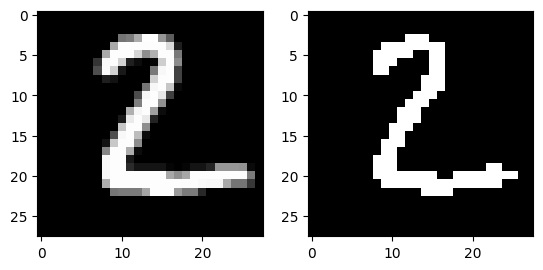

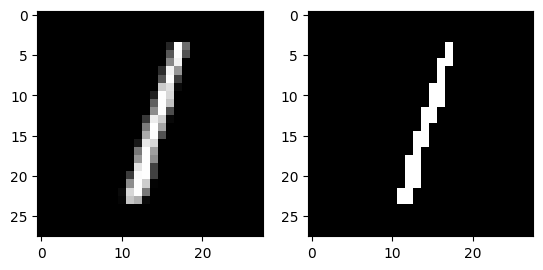

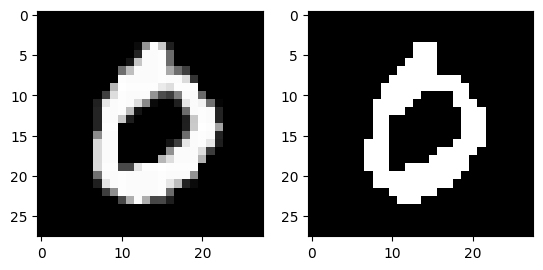

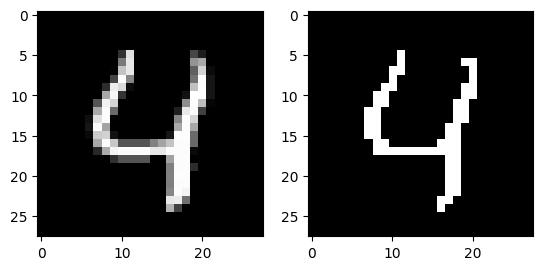

In [65]:
# test
sdae_model.eval()
for i, data in enumerate(test_loader):
    if i < 5:
        x, _ = data
        x = x.to(device)  # GPU로 이동

        out_x = sdae_model(x).cpu().detach()  # 모델 결과를 CPU로 옮기기

        fig = plt.figure()
        rows = 1
        cols = 2
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(x.cpu().numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(out_x.numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기

        plt.show()
